In [1]:
import sys
import os

# Adiciona o diretório correto ao path
# Ajuste o caminho conforme sua estrutura real
sys.path.insert(0, os.getcwd())

# Se os arquivos estão em subpastas, ajuste:# Importar funções de pertinência do core
from fuzzy_systems.learning.wang_mendel import WangMendelLearning
from fuzzy_systems.inference import MamdaniSystem

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt

# Configurar matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

print("✅ Bibliotecas importadas com sucesso!")
print(f"   Versão do NumPy: {np.__version__}")


from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

✅ MamdaniLearning implementado com sucesso!

Características:
  • Aprendizado por gradiente: batch, online, mini-batch
  • Otimização metaheurística: PSO, DE, GA
  • Defuzzificação: COG e COS
  • Caching de ativações para otimização eficiente
  • Extração de regras linguísticas
✅ Módulo de EDO Fuzzy implementado com sucesso!

Características:
  • Integração completa com fuzzy_systems.core
  • Suporte a FuzzySet, triangular, gaussiana, trapezoidal
  • Método de α-níveis vetorizado
  • Paralelização automática (joblib)
  • Condições iniciais e parâmetros fuzzy
  • Visualização de envelopes por α-nível
✅ Bibliotecas importadas com sucesso!
   Versão do NumPy: 1.26.4


In [2]:
iris = load_iris()
X = iris.data  # Shape (150, 4) - 4 features
y = iris.target

feature_names = iris.feature_names 
class_names = iris.target_names

# feature_names = ['Petal Length (cm)', 'Petal Width (cm)']
# class_names = ['setosa', 'versicolor', 'virginica']


# Estatísticas
print('📈 Estatísticas:')
for i, name in enumerate(feature_names):
    print(f'   {name:20s}: [{X[:, i].min():.2f}, {X[:, i].max():.2f}]')
print()

# Distribuição de classes
print('🌸 Distribuição de classes:')
for i, name in enumerate(class_names):
    count = np.sum(y == i)
    print(f'   {name:12s}: {count} amostras')

📈 Estatísticas:
   sepal length (cm)   : [4.30, 7.90]
   sepal width (cm)    : [2.00, 4.40]
   petal length (cm)   : [1.00, 6.90]
   petal width (cm)    : [0.10, 2.50]

🌸 Distribuição de classes:
   setosa      : 50 amostras
   versicolor  : 50 amostras
   virginica   : 50 amostras


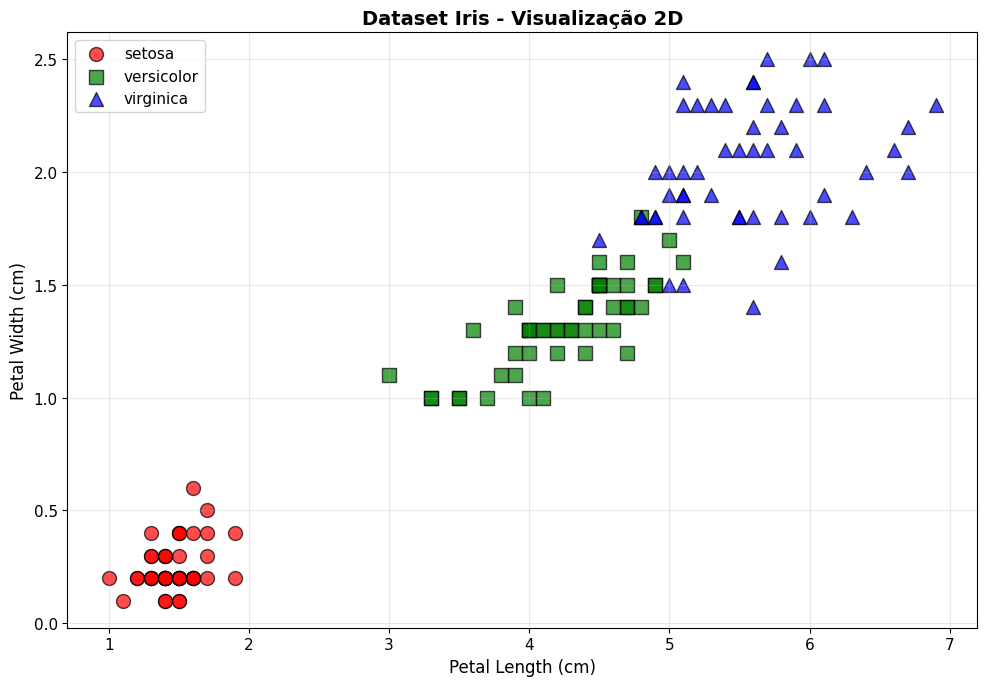

✅ As classes são visualmente separáveis!


In [3]:
# Scatter plot colorido por classe
plt.figure(figsize=(10, 7))

colors = ['red', 'green', 'blue']
markers = ['o', 's', '^']

for i, (name, color, marker) in enumerate(zip(class_names, colors, markers)):
    idx = y == i
    plt.scatter(X[idx, 2], X[idx, 3], 
                c=color, marker=marker, s=100, 
                label=name, alpha=0.7, edgecolors='black')

plt.xlabel('Petal Length (cm)', fontsize=12)
plt.ylabel('Petal Width (cm)', fontsize=12)
plt.title('Dataset Iris - Visualização 2D', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('✅ As classes são visualmente separáveis!')

In [4]:
# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

print("="*70)
print("🌸 WANG-MENDEL CLASSIFICATION - IRIS DATASET")
print("="*70)


print(f"\n📊 Dataset Information:")
print(f"   • Samples: {X.shape[0]}")
print(f"   • Features: {X.shape[1]} ({', '.join(feature_names)})")
print(f"   • Classes: {len(class_names)} ({', '.join(class_names)})")

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

print(f"\n   • Target shape: {y.shape} → One-hot: {y_onehot.shape}")

# Train-test split
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X, y_onehot, test_size=0.3, random_state=42, stratify=y
)
y_train = np.argmax(y_train_onehot, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

print(f"\n   • Train samples: {X_train.shape[0]}")
print(f"   • Test samples: {X_test.shape[0]}")


🌸 WANG-MENDEL CLASSIFICATION - IRIS DATASET

📊 Dataset Information:
   • Samples: 150
   • Features: 4 (sepal length (cm), sepal width (cm), petal length (cm), petal width (cm))
   • Classes: 3 (setosa, versicolor, virginica)

   • Target shape: (150,) → One-hot: (150, 3)

   • Train samples: 105
   • Test samples: 45


In [5]:
# ============================================================================
# 2. CREATE FUZZY SYSTEM
# ============================================================================

print(f"\n{'='*70}")
print("🔧 CREATING FUZZY SYSTEM")
print("="*70)

# Create Mamdani system
sistema = MamdaniSystem(name='IrisClassifier')

# Add input variables with 3 fuzzy partitions each
n_partitions = 3
partition_names = ['low', 'medium', 'high']

for i, feature_name in enumerate(feature_names):
    # Get feature range
    x_min = float(X_train[:, i].min())
    x_max = float(X_train[:, i].max())
    margin = (x_max - x_min) * 0.05
    
    # Add input variable
    sistema.add_input(feature_name, (x_min - margin, x_max + margin))
    
    # Add fuzzy terms
    x_range = (x_max + margin) - (x_min - margin)
    step = x_range / (n_partitions - 1)
    
    for j, term_name in enumerate(partition_names):
        center = (x_min - margin) + j * step
        left = max(x_min - margin, center - step)
        right = min(x_max + margin, center + step)
        
        if j == 0:
            params = [x_min - margin, x_min - margin, center + step]
        elif j == n_partitions - 1:
            params = [center - step, x_max + margin, x_max + margin]
        else:
            params = [left, center, right]
        
        sistema.add_term(feature_name, term_name, 'triangular', params)
    
    print(f"   ✓ {feature_name}: {n_partitions} terms")

# Add output variables (one per class, binary: no/yes)
for i, class_name in enumerate(class_names):
    sistema.add_output(class_name, (0, 1))
    sistema.add_term(class_name, 'no', 'triangular', [0, 0, 1.0])
    sistema.add_term(class_name, 'yes', 'triangular', [0, 1, 1])
    print(f"   ✓ Output '{class_name}': binary (no/yes)")

print(f"\n   Total variables: {len(sistema.input_variables)} inputs, {len(sistema.output_variables)} outputs")


🔧 CREATING FUZZY SYSTEM
   ✓ sepal length (cm): 3 terms
   ✓ sepal width (cm): 3 terms
   ✓ petal length (cm): 3 terms
   ✓ petal width (cm): 3 terms
   ✓ Output 'setosa': binary (no/yes)
   ✓ Output 'versicolor': binary (no/yes)
   ✓ Output 'virginica': binary (no/yes)

   Total variables: 4 inputs, 3 outputs


In [6]:
# ============================================================================
# 3. TRAIN WITH WANG-MENDEL
# ============================================================================

print(f"\n{'='*70}")
print("🤖 TRAINING WITH WANG-MENDEL ALGORITHM")
print("="*70)

# Create Wang-Mendel learner with scaling enabled
wm = WangMendelLearning(
    sistema, 
    X_train, 
    y_train_onehot,
    task='auto',  # Will auto-detect classification
    scale_classification=True,
    verbose_init=True
)

# Train
sistema_treinado = wm.fit(verbose=True)

# Get training statistics
stats = wm.get_training_stats()
print(f"\n📈 Training Statistics:")
print(f"   • Task type: {stats['task']}")
print(f"   • Candidate rules: {stats['candidate_rules']}")
print(f"   • Final rules: {stats['final_rules']}")
print(f"   • Conflicts resolved: {stats['conflicts_resolved']}")
print(f"   • Rule coverage: {stats['final_rules']}/{n_partitions**4} possible combinations")




🤖 TRAINING WITH WANG-MENDEL ALGORITHM

📏 Computed achievable output ranges:
   setosa: universe=(0, 1), achievable=[0.3337, 0.6670]
   versicolor: universe=(0, 1), achievable=[0.3337, 0.6670]
   virginica: universe=(0, 1), achievable=[0.3337, 0.6670]
🔄 Starting Wang-Mendel Algorithm...
   Task: CLASSIFICATION
   Data: 105 samples, 4 inputs, 3 outputs
   Classes: 3
   Output scaling: ENABLED (structure-based)

📊 Step 2: Generating candidate rules...
   Candidate rules generated: 15

🔍 Step 4: Resolving conflicts...
   Conflicts found: 2
   Final rules: 13

🔧 Step 5: Creating final system...
   ✓ 13 rules added to system

✅ Training completed!
   Rules generated: 13
   Conflicts resolved: 2

📈 Training Statistics:
   • Task type: classification
   • Candidate rules: 15
   • Final rules: 13
   • Conflicts resolved: 2
   • Rule coverage: 13/81 possible combinations


In [7]:
# ============================================================================
# 4. MAKE PREDICTIONS
# ============================================================================

print(f"\n{'='*70}")
print("🎯 MAKING PREDICTIONS")
print("="*70)

# Predict on test set
y_pred = wm.predict(X_test)
y_proba = wm.predict_proba(X_test)

# Calculate accuracy
accuracy_train = accuracy_score(y_train, wm.predict(X_train))
accuracy_test = accuracy_score(y_test, y_pred)

print(f"\n📊 Performance Metrics:")
print(f"   • Training accuracy: {accuracy_train:.4f} ({accuracy_train*100:.2f}%)")
print(f"   • Test accuracy: {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")

# Classification report
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


🎯 MAKING PREDICTIONS

📊 Performance Metrics:
   • Training accuracy: 0.9238 (92.38%)
   • Test accuracy: 0.8667 (86.67%)

📋 Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.71      1.00      0.83        15
   virginica       1.00      0.60      0.75        15

    accuracy                           0.87        45
   macro avg       0.90      0.87      0.86        45
weighted avg       0.90      0.87      0.86        45




📊 GENERATING VISUALIZATIONS


/Users/1moi6/ambientes/ia/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/1moi6/ambientes/ia/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/1moi6/ambientes/ia/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/1moi6/ambientes/ia/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


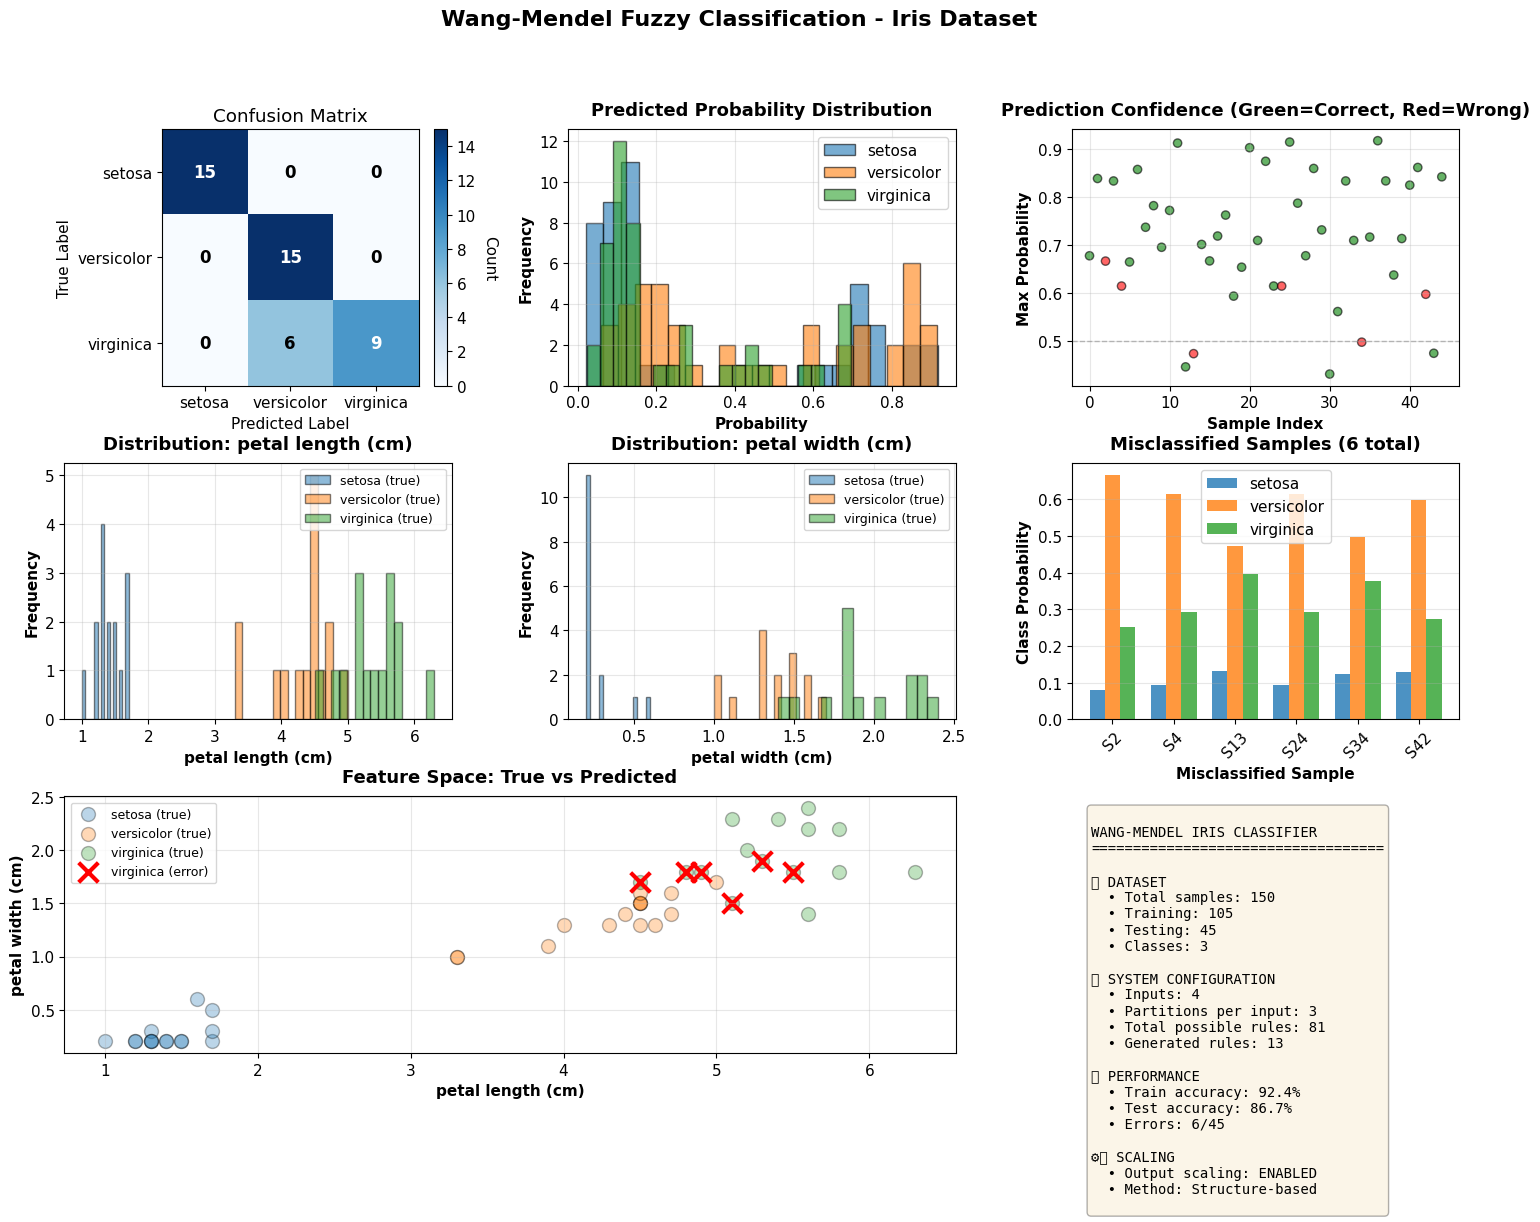


✅ Visualization complete!


In [8]:
# ============================================================================
# 5. VISUALIZATIONS
# ============================================================================

print(f"\n{'='*70}")
print("📊 GENERATING VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ===== Confusion Matrix (SEM SEABORN) =====
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test, y_pred)

# Plot com imshow
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('Count', rotation=270, labelpad=15)

# Configurar eixos
ax1.set(xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names, 
        yticklabels=class_names,
        ylabel='True Label',
        xlabel='Predicted Label',
        title='Confusion Matrix')

# Adicionar valores
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax1.text(j, i, int(cm[i, j]),
                ha="center", va="center", 
                color=text_color, fontsize=12, fontweight='bold')

# ===== Probability Distribution =====
ax2 = fig.add_subplot(gs[0, 1])
for i, class_name in enumerate(class_names):
    ax2.hist(y_proba[:, i], bins=20, alpha=0.6, label=class_name, edgecolor='black')
ax2.set_xlabel('Probability', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Predicted Probability Distribution', fontsize=13, fontweight='bold', pad=10)
ax2.legend()
ax2.grid(True, alpha=0.3)

# ===== Prediction Confidence =====
ax3 = fig.add_subplot(gs[0, 2])
max_proba = y_proba.max(axis=1)
colors = ['green' if p == t else 'red' for p, t in zip(y_pred, y_test)]
ax3.scatter(range(len(y_test)), max_proba, c=colors, alpha=0.6, edgecolors='black')
ax3.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Sample Index', fontsize=11, fontweight='bold')
ax3.set_ylabel('Max Probability', fontsize=11, fontweight='bold')
ax3.set_title('Prediction Confidence (Green=Correct, Red=Wrong)', 
             fontsize=13, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3)

# ===== Feature Distributions by Class (True vs Predicted) =====
for idx, feature_idx in enumerate([2, 3]):  # Petal length and width (most discriminative)
    ax = fig.add_subplot(gs[1, idx])
    
    for i, class_name in enumerate(class_names):
        mask_true = (y_test == i)
        ax.hist(X_test[mask_true, feature_idx], bins=15, alpha=0.5, 
               label=f'{class_name} (true)', edgecolor='black')
    
    ax.set_xlabel(feature_names[feature_idx], fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'Distribution: {feature_names[feature_idx]}', 
                fontsize=13, fontweight='bold', pad=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# ===== Misclassification Analysis =====
ax5 = fig.add_subplot(gs[1, 2])
errors = (y_pred != y_test)
error_indices = np.where(errors)[0]
if len(error_indices) > 0:
    error_proba = y_proba[error_indices]
    x_pos = np.arange(len(error_indices))
    width = 0.25
    
    for i in range(3):
        ax5.bar(x_pos + i*width, error_proba[:, i], width, 
               label=class_names[i], alpha=0.8)
    
    ax5.set_xlabel('Misclassified Sample', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Class Probability', fontsize=11, fontweight='bold')
    ax5.set_title(f'Misclassified Samples ({len(error_indices)} total)', 
                 fontsize=13, fontweight='bold', pad=10)
    ax5.set_xticks(x_pos + width)
    ax5.set_xticklabels([f'S{i}' for i in error_indices], rotation=45)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
else:
    ax5.text(0.5, 0.5, '✅ Perfect Classification!\n No errors found', 
            ha='center', va='center', fontsize=14, fontweight='bold',
            transform=ax5.transAxes)
    ax5.axis('off')

# ===== Pairwise Feature Plot (Most Important Features) =====
ax6 = fig.add_subplot(gs[2, :2])
feature_x, feature_y = 2, 3  # Petal length vs width

for i, class_name in enumerate(class_names):
    # True labels
    mask_true = (y_test == i)
    ax6.scatter(X_test[mask_true, feature_x], X_test[mask_true, feature_y],
               s=100, alpha=0.3, label=f'{class_name} (true)', edgecolors='black')
    
    # Misclassified
    mask_error = (y_test == i) & (y_pred != i)
    if mask_error.sum() > 0:
        ax6.scatter(X_test[mask_error, feature_x], X_test[mask_error, feature_y],
                   s=200, marker='x', linewidths=3, color='red', 
                   label=f'{class_name} (error)')

ax6.set_xlabel(feature_names[feature_x], fontsize=11, fontweight='bold')
ax6.set_ylabel(feature_names[feature_y], fontsize=11, fontweight='bold')
ax6.set_title('Feature Space: True vs Predicted', fontsize=13, fontweight='bold', pad=10)
ax6.legend(fontsize=9, loc='upper left')
ax6.grid(True, alpha=0.3)

# ===== Rules Summary =====
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

summary_text = f"""
WANG-MENDEL IRIS CLASSIFIER
{'='*35}

📊 DATASET
  • Total samples: {len(X)}
  • Training: {len(X_train)}
  • Testing: {len(X_test)}
  • Classes: {len(class_names)}

🔧 SYSTEM CONFIGURATION
  • Inputs: {len(feature_names)}
  • Partitions per input: {n_partitions}
  • Total possible rules: {n_partitions**len(feature_names)}
  • Generated rules: {stats['final_rules']}

🎯 PERFORMANCE
  • Train accuracy: {accuracy_train*100:.1f}%
  • Test accuracy: {accuracy_test*100:.1f}%
  • Errors: {(y_pred != y_test).sum()}/{len(y_test)}

⚙️ SCALING
  • Output scaling: ENABLED
  • Method: Structure-based
"""

ax7.text(0.05, 0.95, summary_text, transform=ax7.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Wang-Mendel Fuzzy Classification - Iris Dataset', 
            fontsize=16, fontweight='bold', y=0.98)

plt.show()

print("\n✅ Visualization complete!")


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'Fuzzy Rule Base Visualization'}, ylabel='Rules'>)

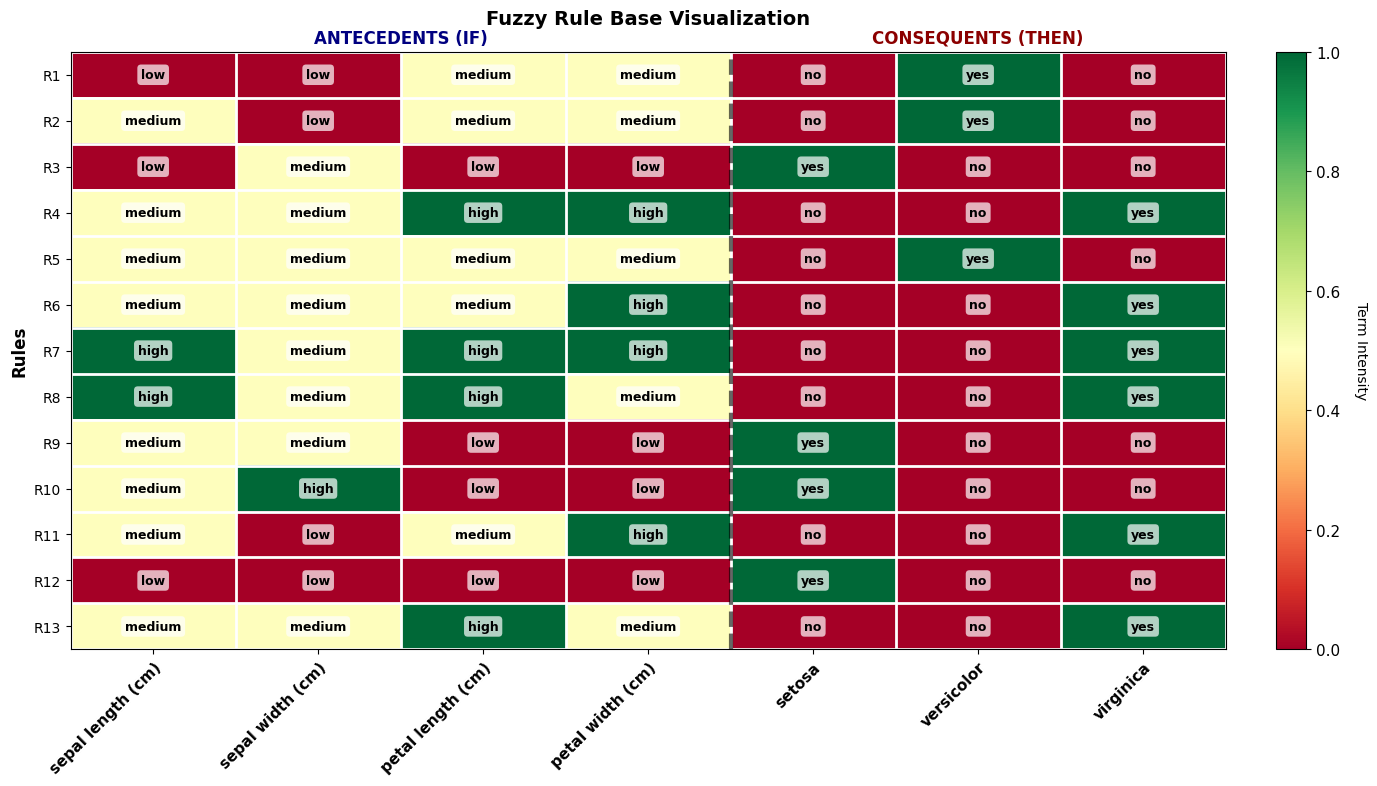

In [9]:
wm.system.plot_rule_matrix()

In [10]:
# Obter memberships
memberships = wm.predict_membership(X_test)

# Para classificação Iris (3 classes × 2 termos cada = 'no'/'yes')
print(memberships['setosa'].shape)  # (45, 2) - 45 amostras, 2 termos

# Primeira amostra
print(f"Setosa - no: {memberships['setosa'][0, 0]:.3f}, yes: {memberships['setosa'][0, 1]:.3f}")
print(f"Versicolor - no: {memberships['versicolor'][0, 0]:.3f}, yes: {memberships['versicolor'][0, 1]:.3f}")
print(f"Virginica - no: {memberships['virginica'][0, 0]:.3f}, yes: {memberships['virginica'][0, 1]:.3f}")

(45, 2)
Setosa - no: 0.629, yes: 0.371
Versicolor - no: 0.584, yes: 0.416
Virginica - no: 0.416, yes: 0.584


In [16]:
# Obter informações detalhadas das primeiras 3 amostras
details = wm.predict_membership_detailed(X_test[:3])

for sample in details:
    print(f"\n=== Amostra {sample['sample_id']} ===")
    print(f"Saídas fuzzy brutas: {sample['raw_outputs']}")
    
    print("\nGraus de pertinência:")
    for var_name, term_memberships in sample['memberships'].items():
        print(f"  {var_name}:")
        for term, degree in term_memberships.items():
            print(f"    {term}: {degree:.4f}")
    
    print("\nTermos dominantes:")
    for var_name, (term, degree) in sample['dominant_terms'].items():
        print(f"  {var_name}: '{term}' ({degree:.4f})")



=== Amostra 0 ===
Saídas fuzzy brutas: {'setosa': 0.37070952966715565, 'versicolor': 0.4159835955915776, 'virginica': 0.5844668361478431}

Graus de pertinência:
  setosa:
    no: 0.6293
    yes: 0.3707
  versicolor:
    no: 0.5840
    yes: 0.4160
  virginica:
    no: 0.4155
    yes: 0.5845

Termos dominantes:
  setosa: 'no' (0.6293)
  versicolor: 'no' (0.5840)
  virginica: 'yes' (0.5845)

=== Amostra 1 ===
Saídas fuzzy brutas: {'setosa': 0.34764579788152555, 'versicolor': 0.6247735479389458, 'virginica': 0.3756557598484191}

Graus de pertinência:
  setosa:
    no: 0.6524
    yes: 0.3476
  versicolor:
    no: 0.3752
    yes: 0.6248
  virginica:
    no: 0.6243
    yes: 0.3757

Termos dominantes:
  setosa: 'no' (0.6524)
  versicolor: 'yes' (0.6248)
  virginica: 'no' (0.6243)

=== Amostra 2 ===
Saídas fuzzy brutas: {'setosa': 0.3630757830959403, 'versicolor': 0.5752939316675009, 'virginica': 0.42518349146786083}

Graus de pertinência:
  setosa:
    no: 0.6369
    yes: 0.3631
  versicolor:

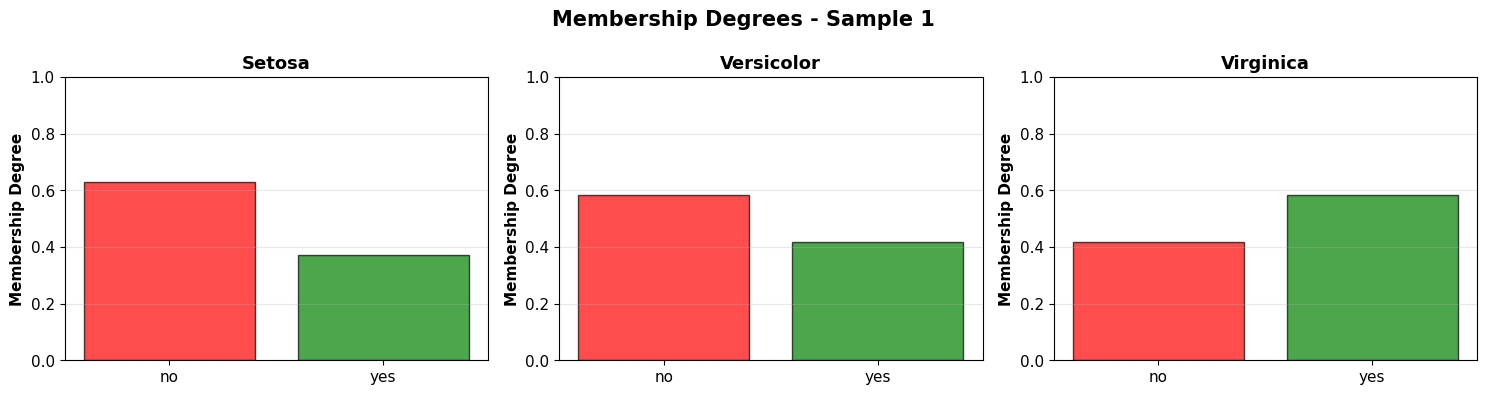

In [17]:
import matplotlib.pyplot as plt

# Obter memberships
memberships = wm.predict_membership(X_test)

# Plot para primeira amostra
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (var_name, ax) in enumerate(zip(['setosa', 'versicolor', 'virginica'], axes)):
    mem = memberships[var_name][0]  # Primeira amostra
    terms = ['no', 'yes']
    
    ax.bar(terms, mem, color=['red', 'green'], alpha=0.7, edgecolor='black')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Membership Degree', fontweight='bold')
    ax.set_title(f'{var_name.capitalize()}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Membership Degrees - Sample 1', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


In [18]:
# Amostras onde nenhum termo tem membership > 0.6
memberships = wm.predict_membership(X_test)

uncertain_samples = []
for i in range(len(X_test)):
    max_memberships = []
    for var_name in ['setosa', 'versicolor', 'virginica']:
        max_mem = memberships[var_name][i].max()
        max_memberships.append(max_mem)
    
    if max(max_memberships) < 0.65:
        uncertain_samples.append(i)

print(f"Amostras incertas: {uncertain_samples}")


Amostras incertas: [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44]
